# Analytics - Linear Regression Challenge

Common end-to-end ML project schedule to take inspirations from

    (1) Look at the Big Picture
            Frame the Problem
            Select a Performance Measure
            Check the Assumptions
    (2) Get the Data
            Create the Workspace
            Download the Data
            Take a Quick Look at the Data Structure
            Create a Test Set
    (3) Discover and Visualize the Data to Gain Insights
            Visualizing Geographical Data
            Looking for Correlations
            Experimenting with Attribute Combinations
    (4) Prepare the Data for Machine Learning Algorithms
            Data Cleaning
            Handling Text and Categorical Attributes
            Custom Transformers
            Feature Scaling
            Transformation Pipelines
    (5) Select and Train a Model
            Training and Evaluating on the Training Set
            Better Evaluation Using Cross-Validation
    (6) Fine-Tune Your Model
            Grid Search
            Randomized Search
            Ensemble Methods (Random forest and Gradient Boosting)
            Analyze the Best Models and Their Errors
            Evaluate Your System on the Test Set


(TODO) My Index: 

    (1) Description of the challenge
    (2) Data description 
    (3) Data visualization 
    (4) Data preprocessing -> Pipeline
    (5) Scope definition
    (6) Models definition
    (7) Model-tuning and cross-validation for optimization!
    (8) Conclusions

## (1) Challenge description

### (TODO) Here we provide a little overview of what we are required to do with my own words (rephrase the problem)

Here attached a csv file containing a sample dataset consisting in (x, y) pairs on which you’ll have to perform a regression task. Here’s what you’ll need to do:

    1.	Open the file and read the data.
    2.	Clean the data if needed.
    3.	Plot the data.
    4.	Fit two different regression models to the data (e.g. curves belonging to two different families).
    5.	Choose a metric for the evaluation of the models and perform the evaluation using cross-validation.
    6.	Plot the predictions from the best model against the data.

We ask you to work in a Jupyter notebook specifying the versions of Python (version 3.x please) and all libraries you use: when you’re done send us the notebook and we’ll execute it and check the results. As an alternative, you can also work in a script: just make sure the results from cross-validation are printed to screen when we execute it via the terminal, and that the plots get saved as files in png format in the same directory containing the script (send us a compressed archive with the script and the plots you produced).


## (2) Dataset overview [TODO]

### (TODO) In this section we are going to load the data, conduct a preliminary analysis on the main characteristics of the data provided to get a sense on how we should proceed in our analysis (data to be cleaned? standardization vs. normalization? univariate vs. bivariate analysis?)

    (1) Complete description
    (2) See what we can add in order to perform a better analysis!

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("analytics_task_data.csv")

In [3]:
df.head()

,x,y
0,8.519119,48.073811
1,12.059918,302.657224
2,11.547357,247.531965
3,10.383055,127.686318
4,8.492261,55.086710


In [4]:
df.describe()

,x,y
count,488.000000,462.000000
mean,9.767819,133.752630
std,1.614540,91.797160
min,7.007803,10.443932
25%,8.380894,59.919619
50%,9.781597,104.201239
75%,11.122550,194.316855
max,12.498972,375.943890


In [5]:
# If there are missing values, we wish to see an overview for each column
if np.array(df.isnull().any()).any() == True: # TODO: This code might need some improvements!
    missing_data_sum = df.isnull().sum()
    

x    12
y    38
dtype: int64


In [6]:
# Wish to go a little more in-depth with these missing values 

# Percentage of missings over total
print(f"""Percentage of missings over total for each column:

        x: {missing_data_sum.x/len(df.x) * 100}% \t 
        y: {missing_data_sum.y/len(df.y) * 100}% 
""")

Percentage of missings over total for each column:

        x: 2.4% 	 
        y: 7.6% 



In [25]:
# Given low percentages of data missing compared to overall size, we might want to proceed to drop them. However, we make a consideration here:
# x -> drop (we might be to impute with sophisticated imputer such as KNN since a simpler one would probably get to a faulty road)
# y -> drop them, but store on an external file that would work as a test data. Why? Well, because we might want to see how the two models perform on data that they have never seen before and plot how the line fit with these values

### Correlation analysis
An important step in regression task is to see how variables are related to each other. In particular, having a simple regression task here, the only relationship we can infer from the correlation is

In [43]:
# Remove missings to calculate correlation coefficient (null values would turn down the coefficient to 0)
df_corr = df.dropna(axis=0)
# Retrieve correlation coefficient
corr_coefs = np.corrcoef(df_corr.x.values,df_corr.y.values,)

print(f"Correlation between explanatory and target variable amounts to: {round(corr_coefs[0][1],2)}")

Correlation between explanatory and target variable amounts to: 0.95


The correlation between the explanatory and the target variables is really high, and this suggests us that most of the variance of the target is explained only by one predictor. The number, along with the fact that we have a relatively high number of observations, is also signaling that this relationship might be modeled quite efficiently to predict future values.

## (3) Data visualization 
[TODO]

#### (TODO) Data visualization is a fundamental step in order to further explore the relationship between predictor(s) and target variable

    (1) Might need the course on Kaggle to do a good job here!
    (2) Univariate vs. Bivariate analysis:
            Boxplots
            Scatter plots
    (3) Remember to add a final evaluation of the curve on the test set!

In [52]:
# Main visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
%matplotlib inline
sns.set(color_codes=True)

<Figure size 1152x432 with 0 Axes>

<Figure size 1152x432 with 0 Axes>

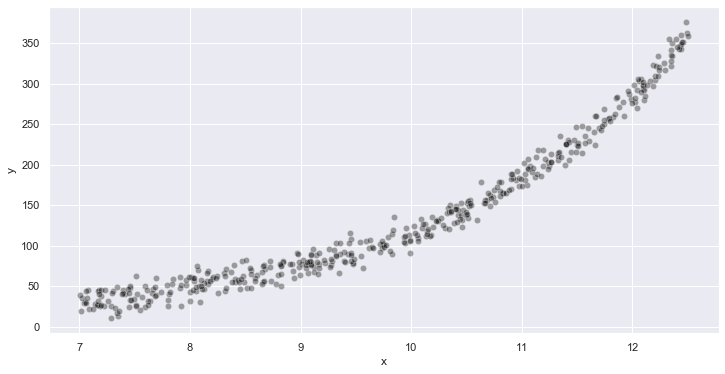

In [73]:
# First plot
plt.figure(figsize=(12,6))
sns.scatterplot(x="x",y="y",data=df,s=40,color="black",alpha=0.35)

From the graph above we can notice that indeed there is a strong relationship between explanatory and target variable. However, it seems that the relationship is non-linear, meaning that we might need something more complex to model than a simple linear regression. Indeed:

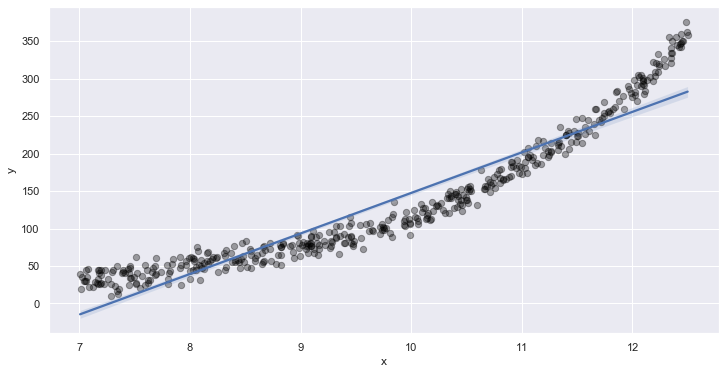

In [74]:
# Scatter-plot with fitted regression line
plt.figure(figsize=(12,6))
sns.regplot(x="x",y="y",data=df,scatter_kws={"s": 40, "color": "black","alpha": 0.35})

Here "seaborn" tried to fit a linear regression model. The result is a model which might have a relatively high score (for instance R2), but it is clearly underfitting the data, meaning that there is high chance that it is unable to predict unosberved data. In order to solve this issue, we might want to introduce high-degree polynomial regression.

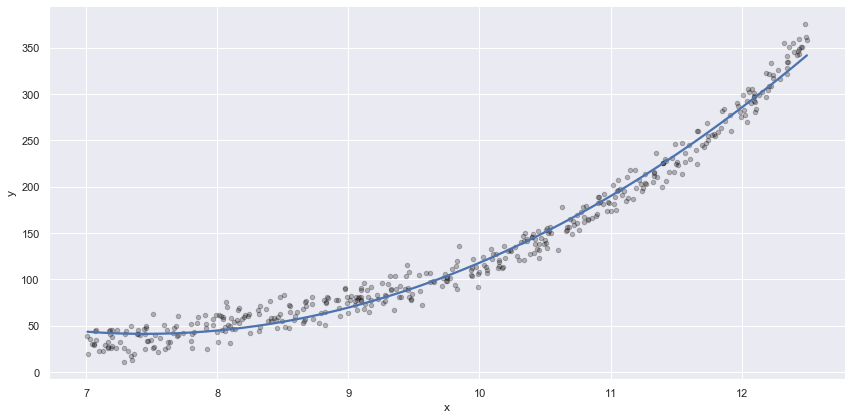

In [85]:
# Scatter-plot with high-degree polynomial regression (degree=2)
sns.lmplot(x="x", y="y", data=df, order=2, ci=None, height=6, aspect=2, scatter_kws={"s": 20, "color": "black", "alpha":0.25})

Polynomial regression seems to be way more accurate in estimating the parameters. Here we set as order of degree the value 2, meaning that the equation representing the line will be a linear regression line with an additional second-degree predictor, which has the role to introduce non-linearity in the model. To conclude, from the graph above we can also notice that the line does not perfectly fit the data. Hence, the question we wish to answer at this point is: can we do better by increasing the polynomial order? 
(TODO: to include or not?) We will see that this is possible and will require hyper-parameter tuning in order to find the optimal order.

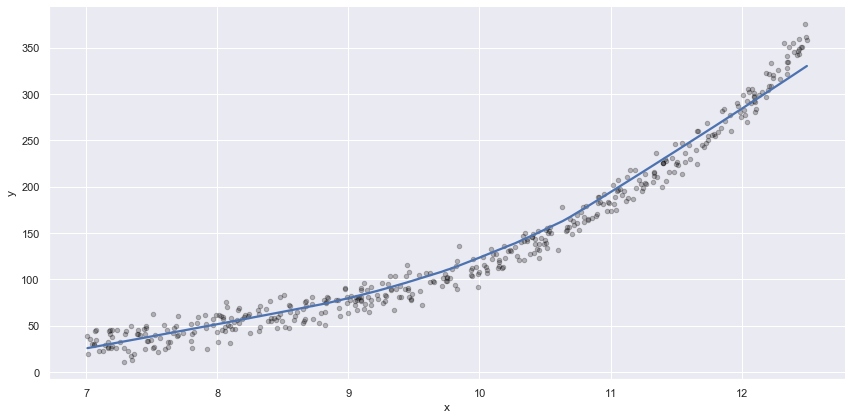

In [87]:
# Non-parametric regression with lowess (locally-weighted-scatterplot-smoothing) smoother
# sns.lmplot(x="x", y="y", data=df, lowess=True, height=6, aspect=2, scatter_kws={"s": 20, "color": "black", "alpha":0.25})

## (4) Data preprocessing + (5) Data Modeling + (6) Parameter Optimizations and Cross-validation + (7) Metrics

#### (TODO) To restructure!

#### (TODO) In this section we are going to defined two different regression models based on the analysis we conducted so far. Based on the visualizations, we already know that the relationship between the two variables is not linear, and for this reason we can exclude a linear regression model which would then underfit our data. We need to add more complexity to the models, and we do by introducing non-linearity in the model: Polynomial!

#### (TODO) Is the model we picked the best we could possibly pick? We might need to twist a little the parameters in order to get the best model and at the same time we wish to take care of underfitting vs. overfitting and bias-variance trade-off issues 

#### (TODO) MSE? RMSE? How should we evaluate the model performance? This might be included in cross-valudation and optimization of hyperparameters (such as the the polynomial line or regression!)

#### (TODO) Based on the analysis we have conducted so far, we want to pick the best model that represents the relationship between the explanatory (x) and the dependent variable (y)

#### (TODO) Data preprocessing step will enable us to get our hands on the data and to correct them in order to avoid as much as possible pitfalls in modeling   

    (1) Drop vs. imputing
    (2) Standardization? Normalization? -> based on the data visualization analysis

### Data Preprocessing

#### Treating missings on the dependent variable ("y")

In [ ]:
# Retrieve indeces for null values
na_y_indeces = df.y[df.y.isnull()].index

# Store values of "x" (for which "y" is null) in a new dataframe with new keys
x_test = pd.DataFrame({"x": df.x.loc[na_y_indeces].values})

# Save the data in a new file -> analytics_task_data_test.csv
x_test.to_csv("analytics_task_data_test.csv",index=False)

# Drop these values from the original dataframe
df.dropna(axis=0,subset=["y"], inplace=True)

# Assert that all proceeded as planned
assert np.in1d(df.x,x_test.x).any() == False

#### Treat missings from explanatory variable ("x") 

In [ ]:
# 1st approach -> Drop them
df.dropna(axis=0,subset=["x"], inplace=True)

#(TODO) -> Want to see whether such an approach improve performances, but I would already consider to drop the missing values for "x" anyway since they represent only the 2.7% of the overall sample. Moreover, the data provided already defines a clear trend (N.B.which might actually be present only in the sample data). 

#### Pipeline Definition

In [ ]:
# Split between explanatory and predictor variable and reshaped to include another axis before splitting
x = df.x.values.reshape(-1,1)
y = df.y.values.reshape(-1,1)

I want to pass the whole execution to a pipeline so that it is easier to replicate, mantain and to read!

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

# from sklearn.preprocessing import Normalizer # NOT YET!
# from sklearn.preprocessing import StandardScaler # NOT YET!

In [ ]:
# Pipeline for the high-degree polynomial model
def get_poly_pipeline(degree):
    # Polynomial-degree transformer with a degree of 2 (parameter to be optimized sooner or later!)
    my_poly_transformer = PolynomialFeatures(degree=degree)
    # Define the model
    my_poly_model = LinearRegression()
    # Define and return the pipeline: bundle together data preprocessing and model definition
    return make_pipeline(my_poly_transformer,my_poly_model)

In [ ]:
# Method to optimize hyper-parameters for the polynomial linear regression model
def get_poly_lr_score(poly_degree=2,kfold=5):
    """
        Execute the following pipeline: Preprocessing, Model definition, Model fitting with cross validation 

            Input: 
                (1) poly_degree: set the highest degree polynomial in the regression equation
                (2) kfold: set the number of splits performed by cross validation 
 
            Output:
                (1) (TODO) the average score produced from cross validation with 
    """

    # Retrieve the pipeline for the polynomial regression model 
    my_pipeline = get_poly_pipeline(degree=poly_degree)
    # Perform K-fold cross validation on the pipeline with a negative mean absolute error as evaluation metric for the model at each split
    # (TODO) (N.B.) each scores is multiply by 1 in order to resotre the minimization problem: we want to get the lowest possible scores for that metric
    scores = (-1)*cross_val_score(my_pipeline,x,y,cv=5,scoring = "neg_mean_absolute_error")
    # (5) Return the score as an average of the MSE on different train-validation splits
    return scores.mean()

In [ ]:
# Now we need to balance the bias-variance tradeoff in order to avoid as much as possible the risk of overfitting or underfitting.
# How? We use the function we have just defined for optimization purposes: we want to retrieve the best parameter for the model

# Define a range of possible polynomial degrees that goes from 2 to 20 (i.e. in the polynomial regression equation, this would mean from x**2 to x**30 [highly non-linear relationship])
degrees = range(2,30)
# Define the average scores for each of the possible values
scores = [get_poly_lr_score(degree) for degree in degrees]
# Collect these in a dictionary with key-value pairs
scores_dict = dict(zip(degrees,scores))

In [ ]:
# Visualize the results
plt.plot(list(scores_dict.keys()),list(scores_dict.values()))

In [ ]:
# Now we want to retrieve the best performing parameter for the model
degree_best = min(scores_dict,key=scores_dict.get)

### Let's define the final model and predict on test data

Pipeline definition and fit

In [ ]:
# Pipeline for the high-degree polynomial model
my_poly_model_best = get_poly_pipeline(degree_best)
# Fit the model on the whole dataset
my_poly_model_best.fit(x,y);

Retrieving test data and producing predictions

In [ ]:
# Read the data
df_test = pd.read_csv("analytics_task_data_test.csv")
x_test = df_test.x.values.reshape(-1,1)

# Pipeline the data in order to make preprocessing also on test data and predictions
y_poly_preds = my_poly_model_best.predict(x_test)

In [ ]:
# Try to plot with older curve!
import operator

# Normal plot!
plt.scatter(x, y, s=10)

# # sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x_test,y_poly_preds), key=sort_axis)
x_plot, y_plot = zip(*sorted_zip)
plt.scatter(x_plot, y_plot, color='m', s=20)

## (Bonus) Results
Here goes the result of the test data defined initially!

In [ ]:
import operator

plt.scatter(x, y, s=10)

# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x_valid,y_poly_preds), key=sort_axis)
x_plot, y_plot = zip(*sorted_zip)
plt.plot(x_plot, y_plot, color='m')

## (8) Conclusions
#### (TODO) What can we conclude from this analysis? Write a little description summarizing the findings and how we approach a final solution